In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.cluster import AgglomerativeClustering

In [2]:
sparql = SPARQLWrapper("http://Vins-Macbook.local:7200/repositories/PCA_Ontology")

# Define the SPARQL query to extract ESG observations.
sparql.setQuery("""

PREFIX ex: <http://example.org/esg#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
 
SELECT DISTINCT ?company ?year ?metric ?category ?value ?pillar ?unit ?model 
WHERE {
  ?obs a ex:ESGObservation ;
       ex:hasCompany ?company ;
       ex:hasYear ?year ;
       ex:hasMetric ?metric ;
       ex:hasCategory ?category ;
       ex:hasValue ?value ;
       ex:hasPillar ?pillar ;
       ex:hasUnit ?unit ;
       ex:belongsToIndustry ex:semiconductors .
 
  ?model ex:relatedToMetric ?metric .
}
ORDER BY ?company ?year ?metric

""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [3]:
records = []

for result in results["results"]["bindings"]:
    # Extract full metric name
    metric_full = result["metric"]["value"].split("#")[-1]

    # Split the metric into metric_name and industry if underscore exists
    if "_" in metric_full:
        metric_parts = metric_full.rsplit("_", 1)  # safer if metric names have underscores
        metric_name = metric_parts[0]
        industry = metric_parts[1]
    else:
        metric = metric_full
        industry = "Unknown"

    record = {
        "company": result["company"]["value"].split("#")[-1],
        "year": result["year"]["value"],
        "metric": metric_name,
        "industry": industry,
        "category": result["category"]["value"].split("#")[-1],
        "value": float(result["value"]["value"]),
        "pillar": result["pillar"]["value"].split("#")[-1],
        "unit": result["unit"]["value"],
        "model": result["model"]["value"].split("#")[-1]
    }
    records.append(record)

In [4]:
sc_df = pd.read_csv("/Users/vinantipathare/Desktop/Docs/CS Project/capstone-project-2025-t1-25t1-9900-t12a-chocolate/Normalized_Data/semiconductors_sasb_final.csv")
bp_df = pd.read_csv("/Users/vinantipathare/Desktop/Docs/CS Project/capstone-project-2025-t1-25t1-9900-t12a-chocolate/Normalized_Data/biopharma_sasb_final.csv")

In [5]:
# Create DataFrame from records
df_raw_sc = pd.DataFrame(records)
# Create a unique identifier for each entity (company_year)
df_raw_sc["entity"] = df_raw_sc["company"] + "_" + df_raw_sc["year"]
# Pivot: rows = entity, columns = metric, values = value
df_pivot = df_raw_sc.pivot_table(index="entity", columns="metric", values="value")
# Replace 0 values with NaN (assuming zeros indicate missing/unreported values)
df_pivot = df_pivot.replace(0, np.nan)
# # Drop columns with more than 90% missing values
# threshold = 0.8
# cols_to_keep = [col for col in df_pivot.columns if df_pivot[col].isnull().mean() <= threshold]
# df_pivot_filtered = df_pivot[cols_to_keep]
# Compute the median for each metric (column), ignoring NaN
median_values = df_pivot.median()

Explained Variance Ratio per PC: [0.18212951 0.14351948 0.1302591  0.1266842 ]
Cumulative Explained Variance: [0.18212951 0.32564899 0.45590809 0.58259229]


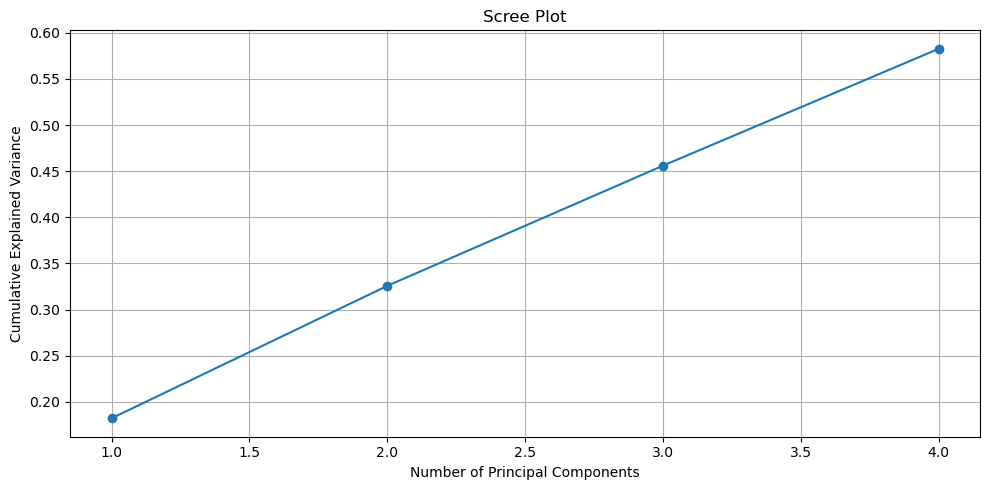

In [6]:
# Impute the missing values with the corresponding column medians
df_pivot_imputed = df_pivot.fillna(median_values)
# Standardization is important for PCA to give each feature equal weight.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pivot_imputed)

# Perform PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio per PC:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance)) # will tell us how much information each PC is capturing 

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

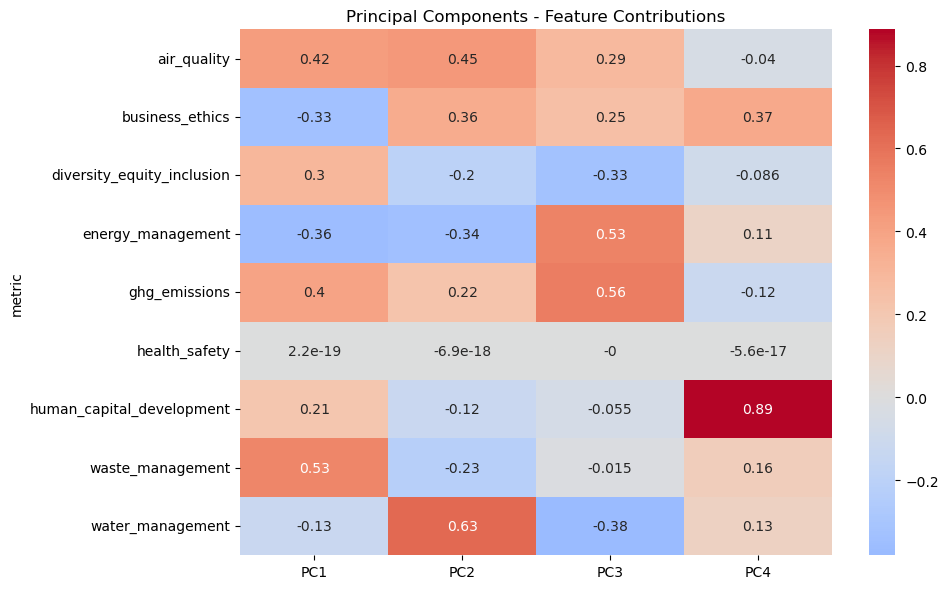

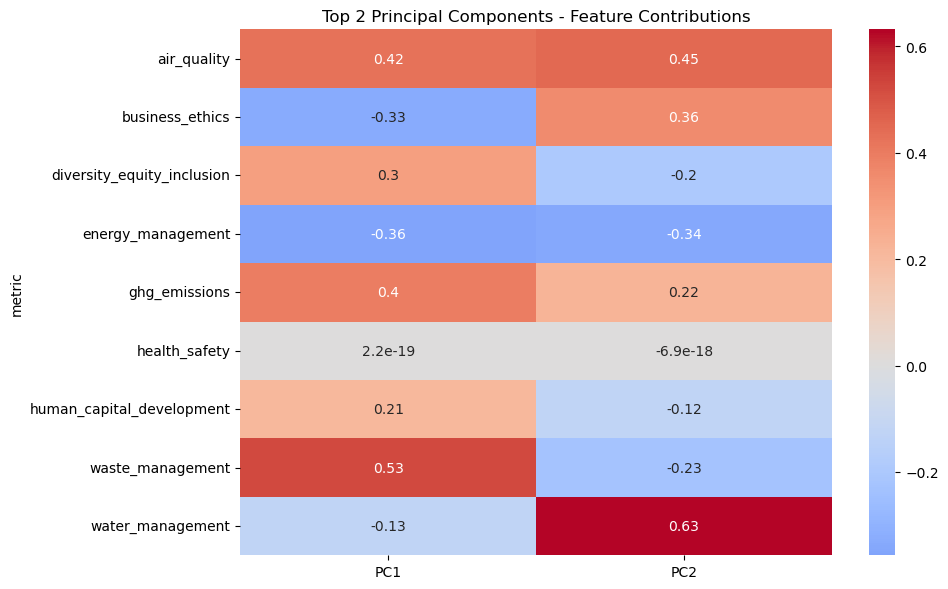

In [7]:

# Loadings indicate how much each original ESG metric contributes to each PC.
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pivot_imputed.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
# Plot a heatmap for the PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :4], annot=True, cmap="coolwarm", center=0)
plt.title("Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()
# Plot a heatmap for the top 2 PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap="coolwarm", center=0)
plt.title("Top 2 Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()

In [8]:

# These scores are the representation of each observation in the PC space.
pca_scores = pd.DataFrame(
    pca_result,
    columns=[f"PC{i+1}" for i in range(pca_result.shape[1])]
)
pca_scores["entity"] = df_pivot_imputed.index
# Merge loadings with the pillar information

# First, create a dataframe of unique metric→pillar mappings from df_raw.
df_metric_pillar = df_raw_sc[['metric', 'pillar']].drop_duplicates()

# loadings index is the metric name, so we reset that index to merge.
loadings_with_pillar = (
    loadings
    .reset_index()                        # "index" is the metric name
    .rename(columns={'index': 'metric'})  
    .merge(df_metric_pillar, on='metric', how='left')
)

# Look at the top metrics (by absolute loading) for a given PC

# top metrics for PC1 (largest absolute value of loading)
pc1_sorted = loadings_with_pillar[['metric', 'pillar', 'PC1']] \
    .assign(loading_abs=loadings_with_pillar['PC1'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC1:")
print(pc1_sorted.head(10))

# top metrics for PC2
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC2']] \
    .assign(loading_abs=loadings_with_pillar['PC2'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC2:")
print(pc2_sorted.head(10))

# top metrics for PC3
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC3']] \
    .assign(loading_abs=loadings_with_pillar['PC3'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC3:")
print(pc2_sorted.head(10))

# top metrics for PC4
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC4']] \
    .assign(loading_abs=loadings_with_pillar['PC4'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC4:")
print(pc2_sorted.head(10))



Top metrics driving PC1:
                        metric         pillar       PC1  loading_abs
11            waste_management         e_risk  0.525112     0.525112
12            waste_management  e_opportunity  0.525112     0.525112
0                  air_quality  g_opportunity  0.424432     0.424432
1                  air_quality         e_risk  0.424432     0.424432
7                ghg_emissions         e_risk  0.397013     0.397013
8                ghg_emissions  e_opportunity  0.397013     0.397013
6            energy_management  e_opportunity -0.356606     0.356606
2              business_ethics         s_risk -0.332842     0.332842
3              business_ethics         g_risk -0.332842     0.332842
4   diversity_equity_inclusion  s_opportunity  0.298428     0.298428
Top metrics driving PC2:
               metric         pillar       PC2  loading_abs
13   water_management         e_risk  0.631851     0.631851
14   water_management  e_opportunity  0.631851     0.631851
0         a

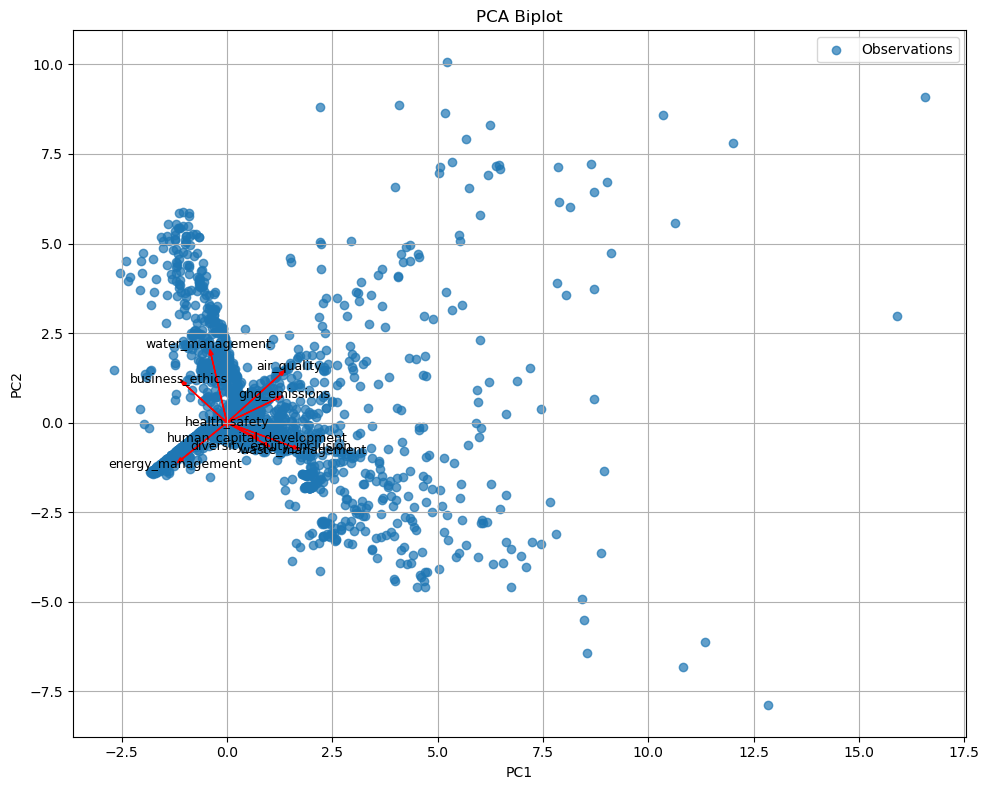

<Figure size 1000x800 with 0 Axes>

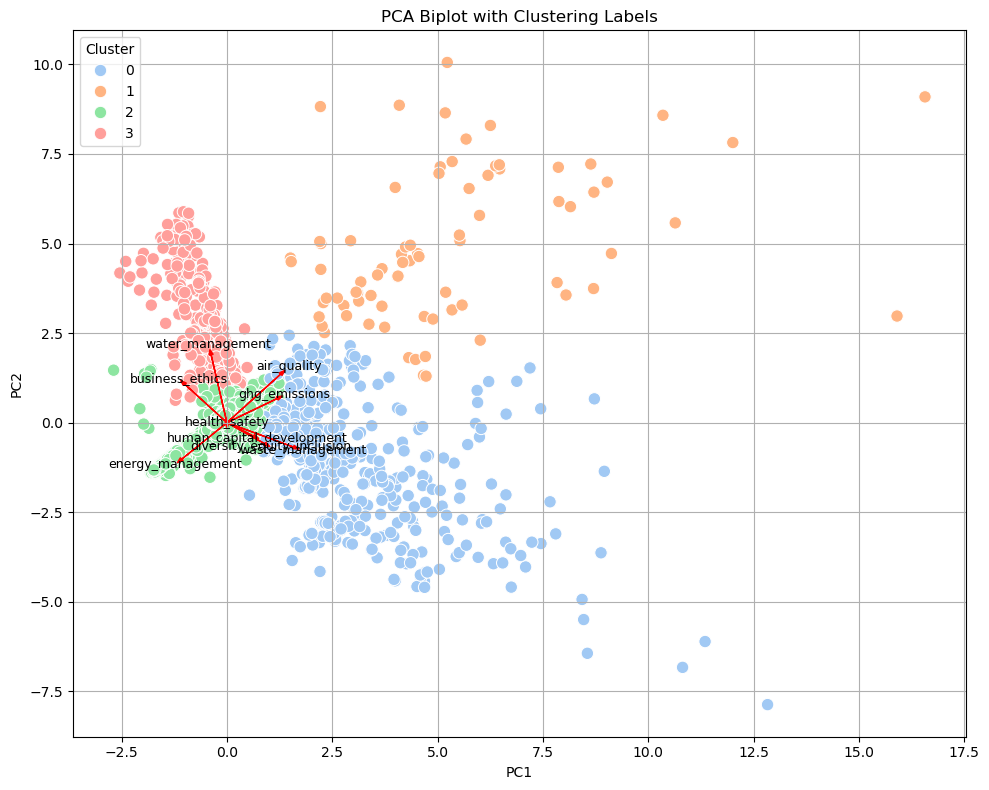

In [9]:

# Create a PCA biplot for PC1 and PC2
plt.figure(figsize=(10, 8))

# Plot the PCA scores (observations)
plt.scatter(pca_scores["PC1"], pca_scores["PC2"], alpha=0.7, label="Observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")

# Scale factor for arrows (to make the vectors visible in the score space)
# You might need to adjust this scaling factor depending on your data.
arrow_scale = 3

# Plot the loadings as arrows
for i, metric in enumerate(loadings.index):
    
    # Get the loadings for PC1 and PC2
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    
    # Plot an arrow for each metric
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    
    # Annotate the arrow with the metric name
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plot the PCA biplot with clustering labels overlayed
plt.figure(figsize=(10, 8))


clustering = AgglomerativeClustering(n_clusters=4)
pca_scores["cluster"] = clustering.fit_predict(pca_scores[["PC1", "PC2"]])

# Plot the PCA biplot with clustering labels overlayed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_scores, palette="pastel", s=80)

# Define an arrow scale factor (adjust as needed)
arrow_scale = 3

# Plot the loadings as arrows
for metric in loadings.index:
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.title("PCA Biplot with Clustering Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:

# Identify which columns are the PC loadings
pc_cols = [col for col in loadings_with_pillar.columns if col.startswith("PC")]

# Melt the loadings DataFrame so that each row contains one metric’s loading for a given PC
df_melted = loadings_with_pillar.melt(
    id_vars=["metric", "pillar"],      # Keep these columns fixed
    value_vars=pc_cols,                # Unpivot the PC columns
    var_name="PC",                     # New column indicating which PC
    value_name="loading"               # New column with the loading value
)

# Create a column for the absolute loading for ranking purposes
df_melted["abs_loading"] = df_melted["loading"].abs()

# For each PC, select the top N metrics by absolute loading
top_n = 10
top_metrics = df_melted.groupby("PC", group_keys=False).apply(lambda g: g.nlargest(top_n, "abs_loading")).reset_index(drop=True)

top_metrics = top_metrics[["PC", "metric", "pillar", "abs_loading"]]

print("Top metrics driving each PC:")
print(top_metrics)
# Sort the results by PC, then by pillar (alphabetically), then by absolute loading (descending)
top_metrics = top_metrics.sort_values(by=["PC", "pillar", "abs_loading"], ascending=[True, True, False])

print("Top metrics driving each PC:")
print(top_metrics)


Top metrics driving each PC:
     PC                      metric         pillar  abs_loading
0   PC1            waste_management         e_risk     0.525112
1   PC1            waste_management  e_opportunity     0.525112
2   PC1                 air_quality  g_opportunity     0.424432
3   PC1                 air_quality         e_risk     0.424432
4   PC1               ghg_emissions         e_risk     0.397013
5   PC1               ghg_emissions  e_opportunity     0.397013
6   PC1           energy_management  e_opportunity     0.356606
7   PC1             business_ethics         s_risk     0.332842
8   PC1             business_ethics         g_risk     0.332842
9   PC1  diversity_equity_inclusion  s_opportunity     0.298428
10  PC2            water_management         e_risk     0.631851
11  PC2            water_management  e_opportunity     0.631851
12  PC2                 air_quality  g_opportunity     0.451125
13  PC2                 air_quality         e_risk     0.451125
14  PC2    

In [11]:
metric_to_pillar_map = {
    "air_quality": "Environmental",
    "business_ethics": "Governance",
    "diversity_equity_inclusion": "Social",
    "energy_management": "Environmental",
    "ghg_emissions": "Environmental",
    "health_safety": "Social",
    "human_capital_development": "Social",
    "waste_management": "Environmental",
    "water_management": "Environmental"
}

loadings["Pillar"] = metric_to_pillar_map  # dictionary mapping metric → pillar

In [12]:
# For PC1
pillar_contrib_pc1 = loadings.groupby("Pillar")["PC1"].apply(lambda x: (x**2).sum())
pillar_contrib_pc1 = pillar_contrib_pc1 / (loadings["PC1"]**2).sum()  # Normalize

print(pillar_contrib_pc1)

# For PC1
pillar_contrib_pc2 = loadings.groupby("Pillar")["PC2"].apply(lambda x: (x**2).sum())
pillar_contrib_pc2 = pillar_contrib_pc2/ (loadings["PC2"]**2).sum()  # Normalize

print(pillar_contrib_pc2)

# For PC1
pillar_contrib_pc3 = loadings.groupby("Pillar")["PC3"].apply(lambda x: (x**2).sum())
pillar_contrib_pc3 = pillar_contrib_pc3 / (loadings["PC3"]**2).sum()  # Normalize

print(pillar_contrib_pc3)

# For PC1
pillar_contrib_pc4 = loadings.groupby("Pillar")["PC4"].apply(lambda x: (x**2).sum())
pillar_contrib_pc4 = pillar_contrib_pc4 / (loadings["PC4"]**2).sum()  # Normalize

print(pillar_contrib_pc4)

Pillar
Environmental    0.756370
Governance       0.110784
Social           0.132846
Name: PC1, dtype: float64
Pillar
Environmental    0.819001
Governance       0.127220
Social           0.053779
Name: PC2, dtype: float64
Pillar
Environmental    0.823287
Governance       0.064449
Social           0.112264
Name: PC3, dtype: float64
Pillar
Environmental    0.069360
Governance       0.135680
Social           0.794959
Name: PC4, dtype: float64


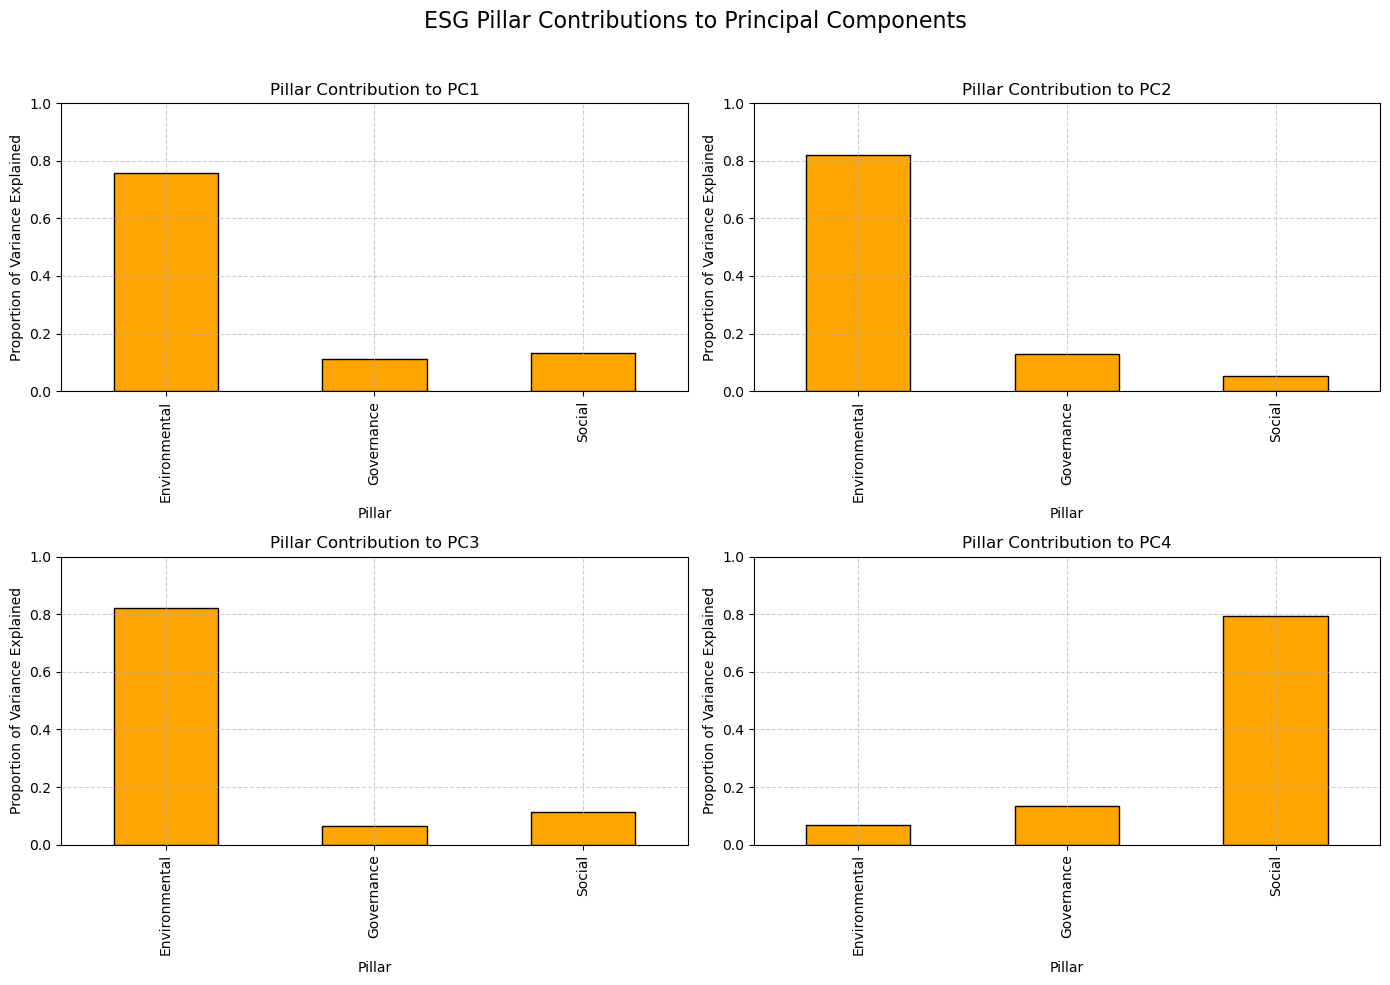

In [13]:
pillar_contrib = {}
for pc in ["PC1", "PC2", "PC3", "PC4"]:
    contrib = loadings.groupby("Pillar")[pc].apply(lambda x: (x**2).sum())
    contrib /= (loadings[pc]**2).sum()  # Normalize to sum to 1
    pillar_contrib[pc] = contrib

pillar_contrib_df = pd.DataFrame(pillar_contrib).fillna(0)  # Fill missing pillars if any

# ---- Step 5: Plot results ----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, pc in enumerate(pillar_contrib_df.columns):
    ax = axes[i]
    pillar_contrib_df[pc].plot(kind='bar', ax=ax, color='orange', edgecolor='black')
    ax.set_title(f'Pillar Contribution to {pc}')
    ax.set_ylabel('Proportion of Variance Explained')
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("ESG Pillar Contributions to Principal Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

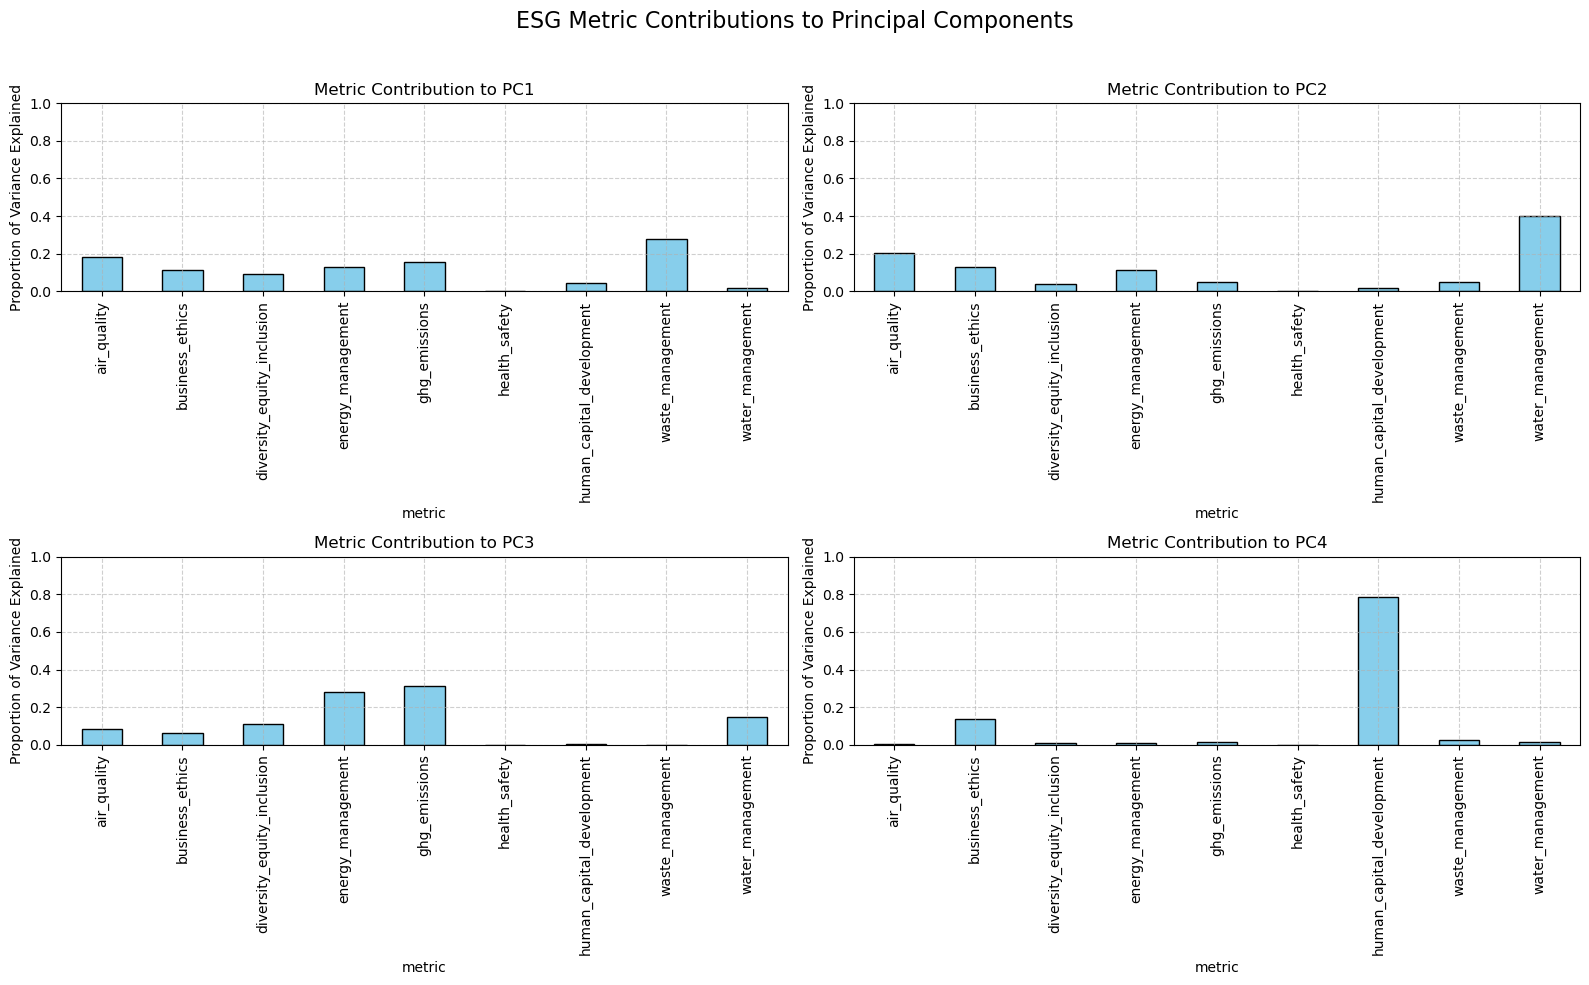

In [14]:
metric_contrib = {}
for pc in ["PC1", "PC2", "PC3", "PC4"]:
    squared = loadings[pc] ** 2
    metric_contrib[pc] = squared / squared.sum()

metric_contrib_df = pd.DataFrame(metric_contrib)

# ---- Step 3: Plot contribution of each metric to each PC ----
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, pc in enumerate(metric_contrib_df.columns):
    ax = axes[i]
    metric_contrib_df[pc].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Metric Contribution to {pc}')
    ax.set_ylabel('Proportion of Variance Explained')
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("ESG Metric Contributions to Principal Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Processing PCA for year: 2016


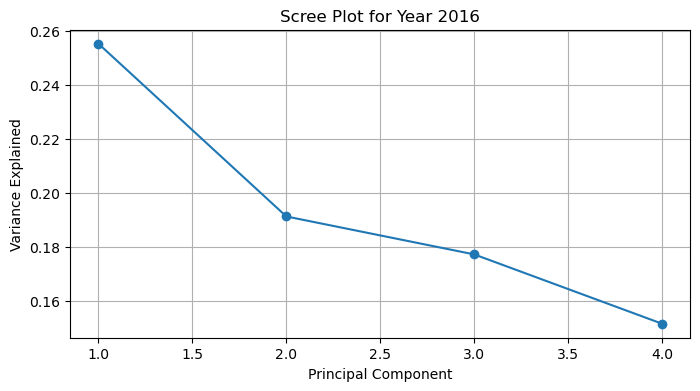

Top contributing metrics to PC1:
metric
air_quality                  0.684697
waste_management             0.574379
ghg_emissions                0.393789
human_capital_development    0.189032
energy_management            0.081806
dtype: float64

Processing PCA for year: 2017


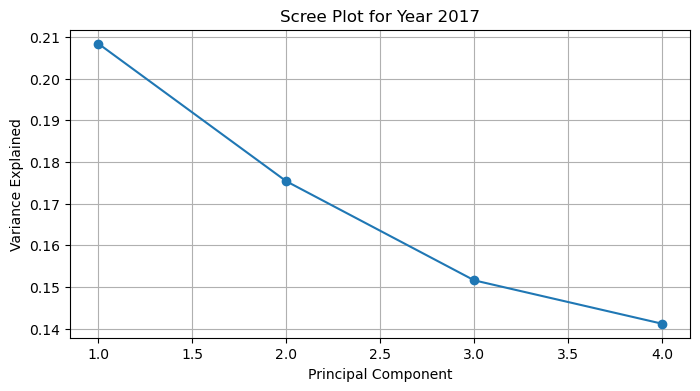

Top contributing metrics to PC1:
metric
air_quality          0.657699
waste_management     0.560188
ghg_emissions        0.455892
energy_management    0.174272
water_management     0.122065
dtype: float64

Processing PCA for year: 2018


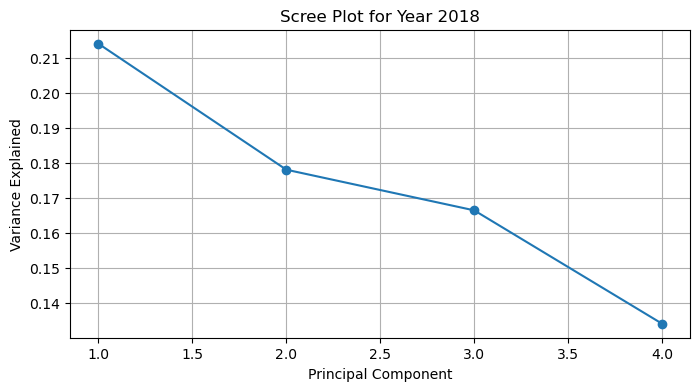

Top contributing metrics to PC1:
metric
waste_management     0.482393
energy_management    0.436089
air_quality          0.417199
water_management     0.366229
ghg_emissions        0.361110
dtype: float64

Processing PCA for year: 2019


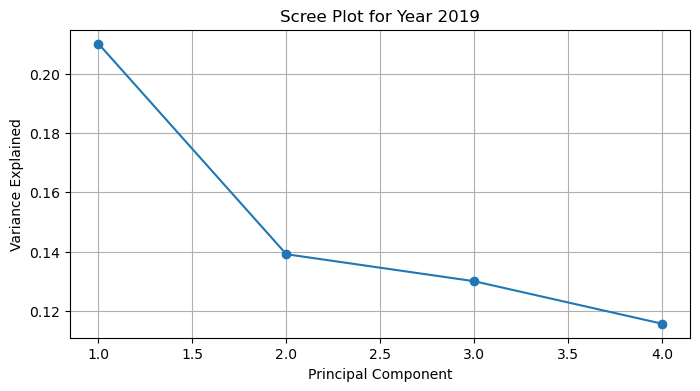

Top contributing metrics to PC1:
metric
business_ethics               0.473782
waste_management              0.459403
health_safety                 0.458378
ghg_emissions                 0.381797
diversity_equity_inclusion    0.312383
dtype: float64

Processing PCA for year: 2020


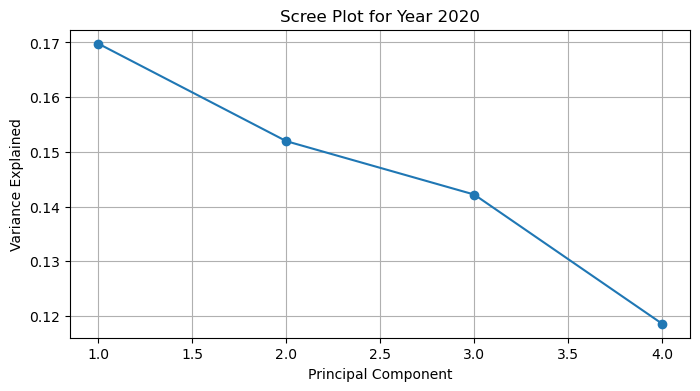

Top contributing metrics to PC1:
metric
health_safety                 0.559998
energy_management             0.429179
diversity_equity_inclusion    0.407200
waste_management              0.342058
ghg_emissions                 0.299443
dtype: float64

Processing PCA for year: 2021


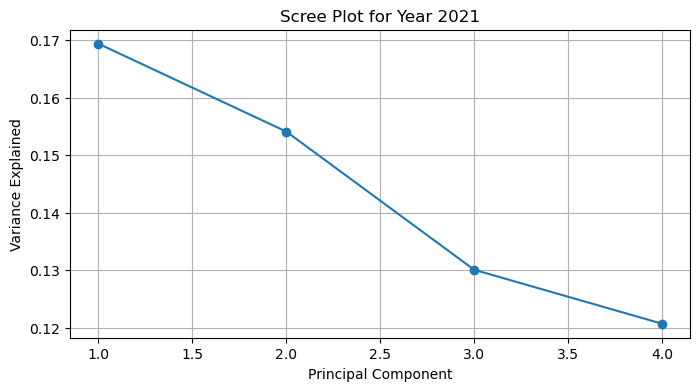

Top contributing metrics to PC1:
metric
business_ethics               0.499158
diversity_equity_inclusion    0.471019
health_safety                 0.453013
waste_management              0.399708
energy_management             0.336904
dtype: float64

Processing PCA for year: 2022


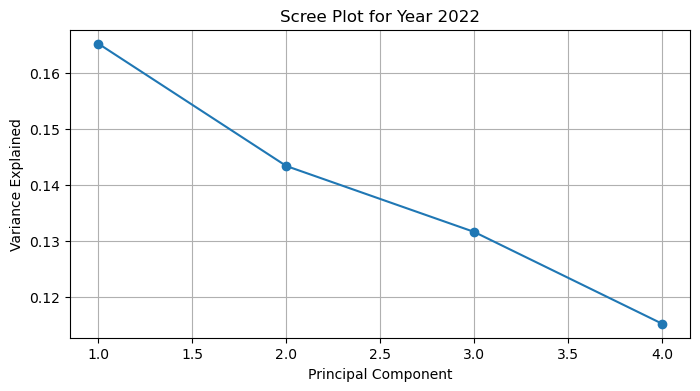

Top contributing metrics to PC1:
metric
waste_management     0.561941
energy_management    0.479383
ghg_emissions        0.391596
business_ethics      0.382871
air_quality          0.220783
dtype: float64

Processing PCA for year: 2023


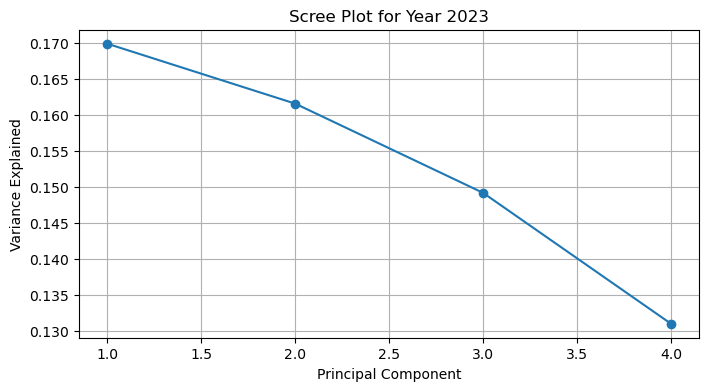

Top contributing metrics to PC1:
metric
air_quality                   0.564952
ghg_emissions                 0.536286
business_ethics               0.422132
diversity_equity_inclusion    0.413997
energy_management             0.159975
dtype: float64

Processing PCA for year: 2024


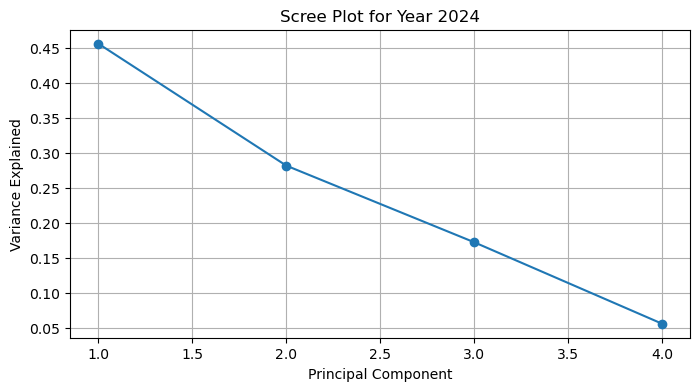

Top contributing metrics to PC1:
metric
energy_management             0.576008
human_capital_development     0.558611
waste_management              0.547793
diversity_equity_inclusion    0.173437
water_management              0.124186
dtype: float64


In [15]:
# Assuming `df` is your full DataFrame and has columns: ['company', 'year', 'metric1', ..., 'metricN']
# First, make sure 'year' is a column in your DataFrame and not part of the index

# Step 1: Loop over unique years
for year in sorted(df_raw_sc['year'].unique()):
    print(f"\nProcessing PCA for year: {year}")
    
    # Step 2: Filter data for the current year
    df_year = df_raw_sc[df_raw_sc['year'] == year]

    # Step 3: Pivot to wide format (rows: company, columns: metric, values: value)
    df_pivot_year = df_year.pivot_table(index='company', columns='metric', values='value')
    
    # Step 4: Handle missing values (fill with mean or 0)
    df_filled = df_pivot_year.fillna(df_pivot_year.mean()) 

    # Step 5: Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_filled)

    # Step 6: Apply PCA
    pca_year = PCA(n_components=min(4, scaled_data.shape[1]))  # use min to avoid dimension errors
    pca_result = pca_year.fit_transform(scaled_data)

    # Step 7: Plot Scree Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(pca_year.explained_variance_ratio_) + 1), 
             pca_year.explained_variance_ratio_, marker='o')
    plt.title(f'Scree Plot for Year {year}')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.grid(True)
    plt.show()

    # Optional: print top contributing metrics for PC1
    pca_loadings = pd.Series(pca_year.components_[0], index=df_filled.columns)
    print("Top contributing metrics to PC1:")
    print(pca_loadings.abs().sort_values(ascending=False).head(5))
